<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ARIMA Model


## Imports


In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
# import sarima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Utilities


In [89]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)
    # Formatter les étiquettes de l'axe des x pour afficher uniquement l'année
    #plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Load and Preview the Dataset


In [90]:
paris_df = pd.read_csv('data/metropoles_consumption/eco2mix-metropoles-tr_light.csv', sep=';')
paris_df.head()

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,243300316,Bordeaux Métropole,Données temps réel,2022-08-09,18:45,2022-08-09T18:45:00+02:00,448.0,ND,421
1,243300316,Bordeaux Métropole,Données temps réel,2022-08-09,19:00,2022-08-09T19:00:00+02:00,520.0,ND,494
2,243300316,Bordeaux Métropole,Données temps réel,2022-08-09,22:30,2022-08-09T22:30:00+02:00,539.0,ND,523
3,243300316,Bordeaux Métropole,Données temps réel,2022-08-10,00:45,2022-08-10T00:45:00+02:00,445.0,ND,429
4,243300316,Bordeaux Métropole,Données temps réel,2022-08-10,03:15,2022-08-10T03:15:00+02:00,408.0,ND,391


In [91]:
# order the dataframe by increasing date, then hour
villes_df = paris_df.sort_values(by=['Date', 'Heures'])
villes_df.head(5)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
182495,200054807,Métropole d'Aix-Marseille-Provence,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,1872.0,NaN,NaN
241099,246700488,Eurométropole de Strasbourg,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,425.0,NaN,NaN
283631,200054781,Métropole du Grand Paris,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,5135.0,NaN,NaN
383233,200046977,Métropole de Lyon,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,1151.0,NaN,NaN
469422,245900410,Métropole Européenne de Lille,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,1013.0,NaN,NaN


In [92]:
# see the number of rows where consumption = 0
print('Number of rows with consumption data = 0: ', len(villes_df[villes_df['Consommation (MW)'] == 0]))

# replace rows where consumption = 0 with the mean of the 3 previous and 3 next values

# get the indices of the rows where consumption = 0
zero_consumption_indices = villes_df[paris_df['Consommation (MW)'] == 0].index

# loop over the indices
for index in zero_consumption_indices:

  # get the mean of the 3 previous and 3 next values
  mean_consumption = villes_df.loc[index-3:index+3, 'Consommation (MW)'].mean()

  # replace the value with the mean
  villes_df.loc[index, 'Consommation (MW)'] = mean_consumption
print('Number of rows with consumption data = 0: ', len(villes_df[villes_df['Consommation (MW)'] == 0]))

Number of rows with consumption data = 0:  799


C:\Users\Martin\AppData\Local\Temp\ipykernel_29052\381615007.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_consumption_indices = villes_df[paris_df['Consommation (MW)'] == 0].index


Number of rows with consumption data = 0:  0


In [93]:
# display nan values
villes_df.isna().sum()



Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)       6990
Production            306703
Echanges physiques    306703
dtype: int64

In [94]:
villes_df.head(50)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
182495,200054807,Métropole d'Aix-Marseille-Provence,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,1872.0,NaN,NaN
241099,246700488,Eurométropole de Strasbourg,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,425.0,NaN,NaN
283631,200054781,Métropole du Grand Paris,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,5135.0,NaN,NaN
383233,200046977,Métropole de Lyon,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,1151.0,NaN,NaN
469422,245900410,Métropole Européenne de Lille,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,1013.0,NaN,NaN
621634,244400404,Nantes Métropole,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,525.0,NaN,NaN
637313,243300316,Bordeaux Métropole,Données temps réel,2021-01-01,00:00,2021-01-01T00:00:00+01:00,774.0,NaN,NaN
14176,245900410,Métropole Européenne de Lille,Données temps réel,2021-01-01,00:15,2021-01-01T00:15:00+01:00,1046.0,NaN,NaN
88427,200046977,Métropole de Lyon,Données temps réel,2021-01-01,00:15,2021-01-01T00:15:00+01:00,1157.0,NaN,NaN
231357,243300316,Bordeaux Métropole,Données temps réel,2021-01-01,00:15,2021-01-01T00:15:00+01:00,792.0,NaN,NaN


In [95]:
# replace rows where consumption = na with the mean of the 3 previous and 3 next values

# get the indices of the rows where consumption is na

na_consumption_indices = paris_df[paris_df['Consommation (MW)'].isna()].index

# loop over the indices
for index in na_consumption_indices:

  # get the mean of the 5 previous and 5 next values
  mean_consumption = paris_df.loc[index-2:index+2, 'Consommation (MW)'].mean()

  # replace the value with the mean
  paris_df.loc[index, 'Consommation (MW)'] = mean_consumption

# drop the rows where 'consumption' is still na
paris_df = paris_df.dropna(subset=['Consommation (MW)'])
# display nan values
paris_df.isna().sum()

Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)          0
Production            306703
Echanges physiques    306703
dtype: int64

In [96]:
villes_df['Consommation (MW)'] = villes_df.groupby('Métropole')['Consommation (MW)'].transform(lambda x: x.fillna(x.mean()))

In [97]:
# display nan values
villes_df.isna().sum()

Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)          0
Production            306703
Echanges physiques    306703
dtype: int64

In [98]:
# get time series of consumption
villes_consumption = {}
for ville in villes_df['Métropole'].unique():
    v_df = villes_df[villes_df['Métropole'] == ville]
    v_df = v_df.sort_values('Date')
    villes_consumption[ville] = v_df.set_index('Date')['Consommation (MW)']
# get accompanying timesteps (date+hour converted to datetime)
villes_time = pd.to_datetime(villes_df['Date'] + ' ' + villes_df['Heures'], format='%Y-%m-%d %H:%M')

In [99]:
villes_consumption

{"Métropole d'Aix-Marseille-Provence": Date
 2021-01-01    1872.000000
 2021-01-01    1799.000000
 2021-01-01    1777.000000
 2021-01-01    1733.000000
 2021-01-01    1669.000000
                  ...     
 2023-12-07    2360.000000
 2023-12-07    2397.000000
 2023-12-07    2292.000000
 2023-12-07    2472.000000
 2023-12-07    1573.548396
 Name: Consommation (MW), Length: 102816, dtype: float64,
 'Eurométropole de Strasbourg': Date
 2021-01-01    425.000000
 2021-01-01    430.000000
 2021-01-01    416.000000
 2021-01-01    401.000000
 2021-01-01    415.000000
                  ...    
 2023-12-07    471.000000
 2023-12-07    458.000000
 2023-12-07    441.000000
 2023-12-07    576.000000
 2023-12-07    424.426713
 Name: Consommation (MW), Length: 102816, dtype: float64,
 'Métropole du Grand Paris': Date
 2021-01-01    5135.000000
 2021-01-01    5255.000000
 2021-01-01    5164.000000
 2021-01-01    5119.000000
 2021-01-01    5126.000000
                  ...     
 2023-12-08    4318.0000

In [100]:
villes_time = pd.to_datetime(villes_df['Date'] + ' ' + villes_df['Heures'], format='%Y-%m-%d %H:%M')
villes_time_with_city = pd.DataFrame({'Date': villes_time, 'Métropole': villes_df['Métropole']})

# Maintenant, vous pouvez utiliser villes_time_with_city pour créer vos graphiques


Métropole d'Aix-Marseille-Provence: 102816


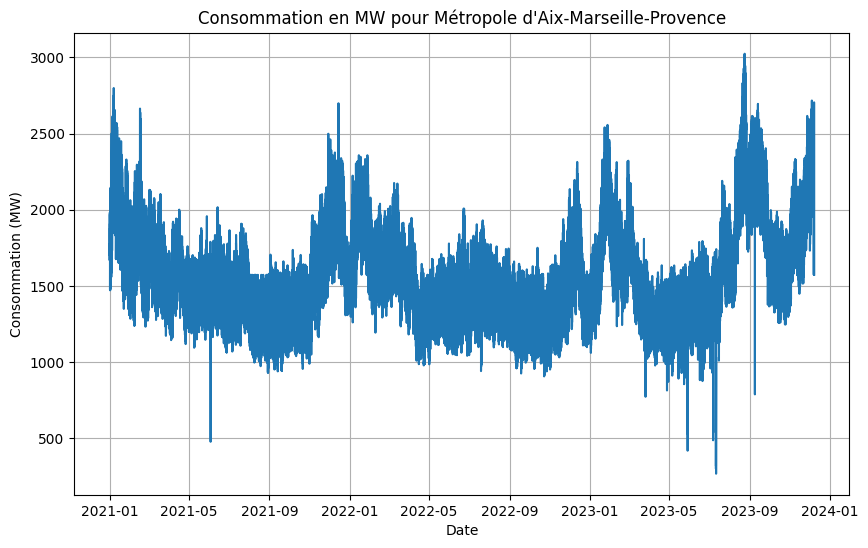

Eurométropole de Strasbourg: 102816


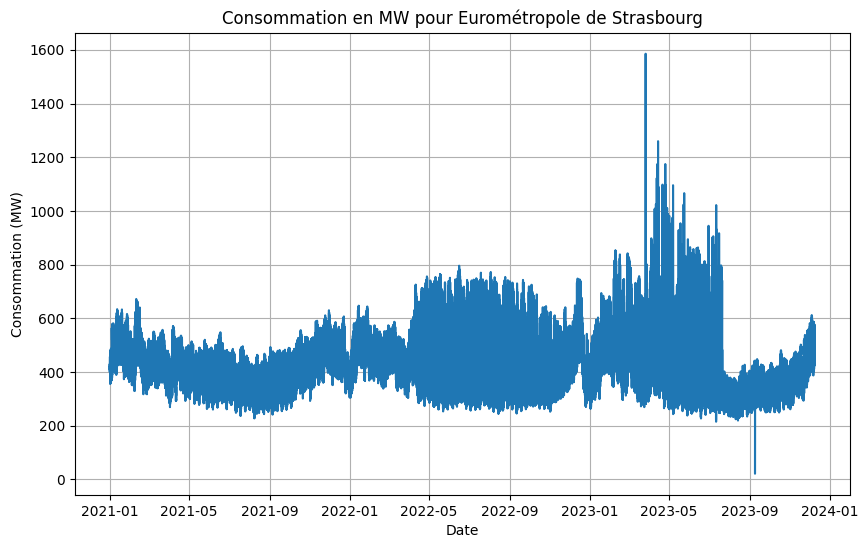

Métropole du Grand Paris: 102912


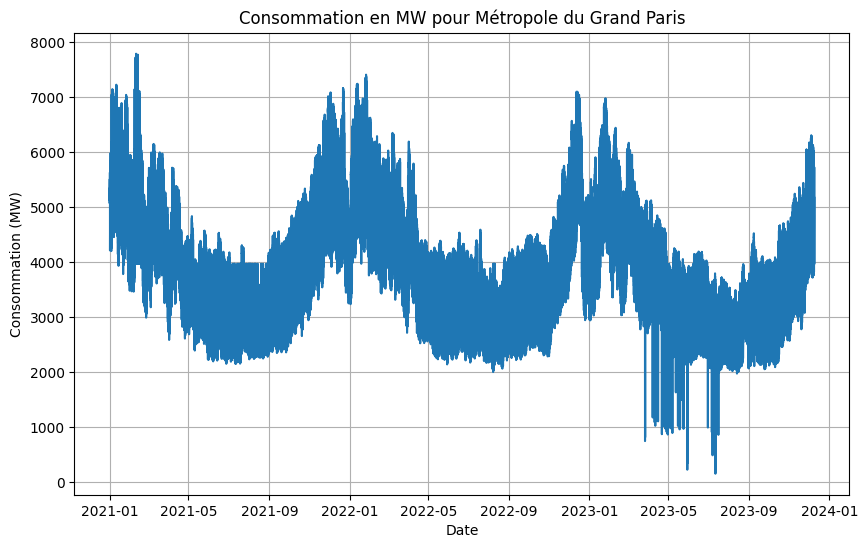

Métropole de Lyon: 102912


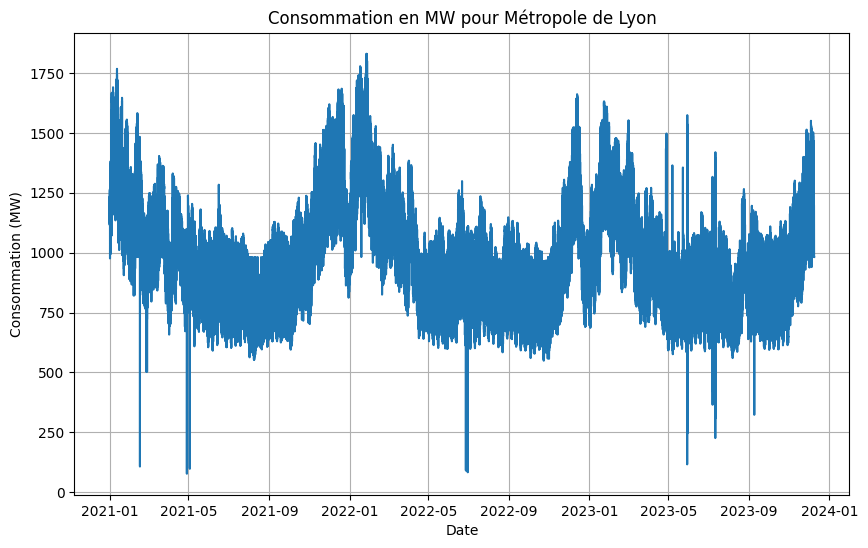

Métropole Européenne de Lille: 102912


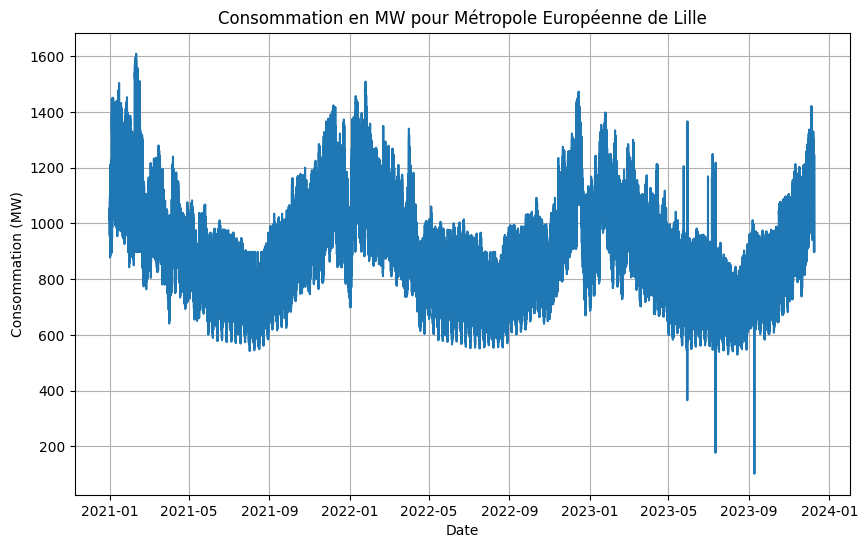

Nantes Métropole: 102912


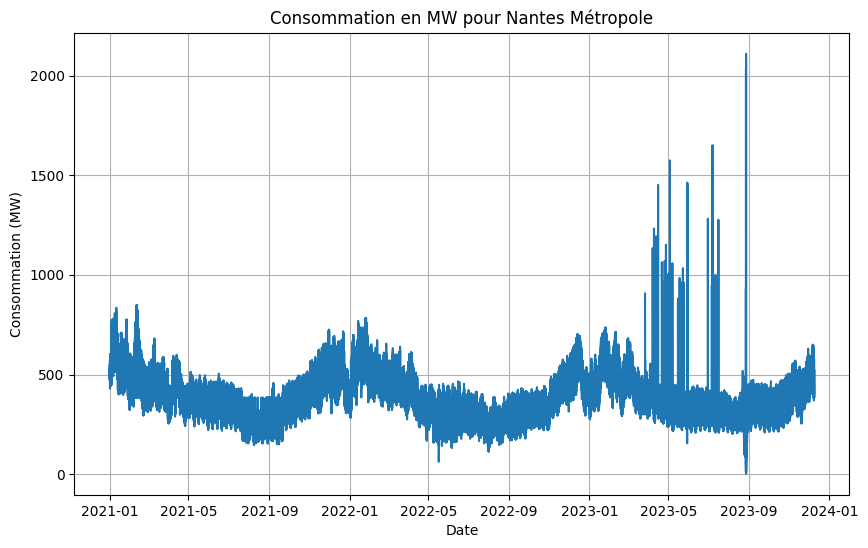

Bordeaux Métropole: 102816


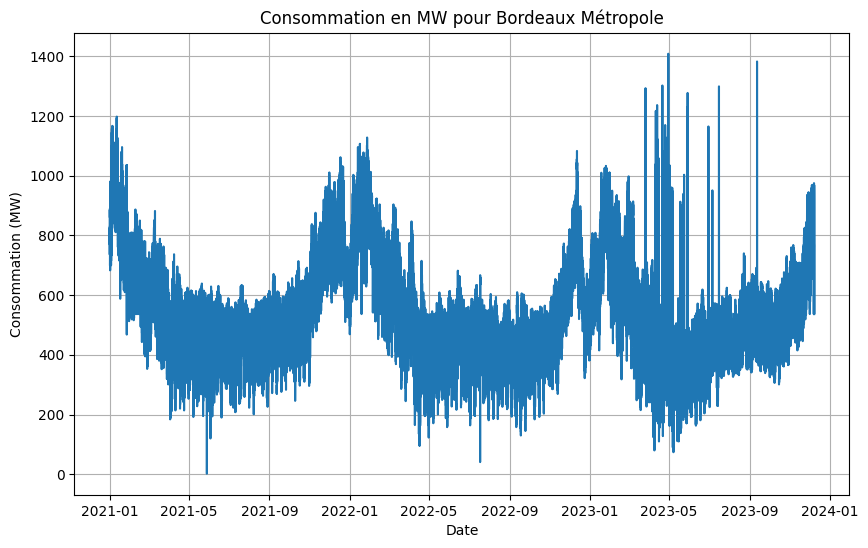

In [101]:
# Plot time series for each city
for ville, consommation in villes_consumption.items():
    time = villes_time_with_city[villes_time_with_city['Métropole'] == ville]['Date']
    series = consommation.values
    # print len of series
    print(f'{ville}: {len(series)}')
    
    # Afficher la consommation pour chaque ville
    plot_series(
        x=time,
        y=series,
        title=f'Consommation en MW pour {ville}',
        xlabel='Date',
        ylabel='Consommation (MW)'
    )


In [102]:
cities_predictions = {}

c:\Python311\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: seasonal_order. After release 0.14, this will raise.
  warnings.warn(


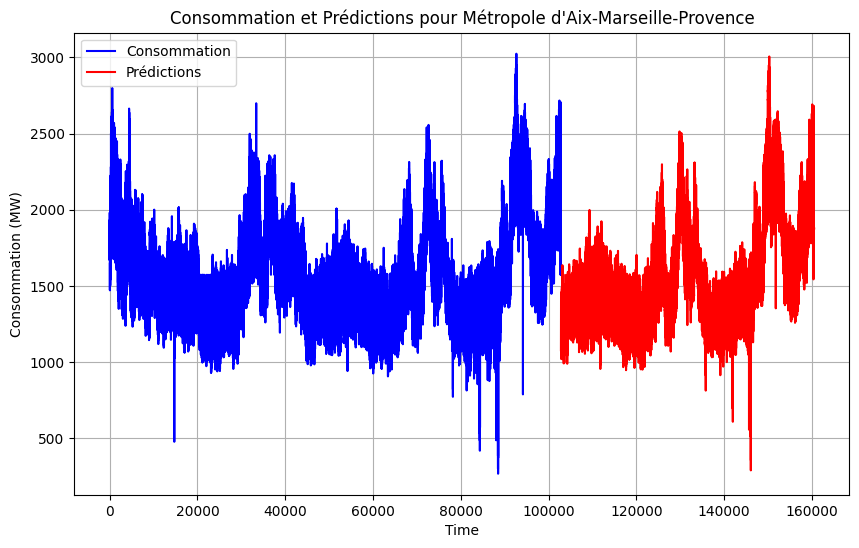

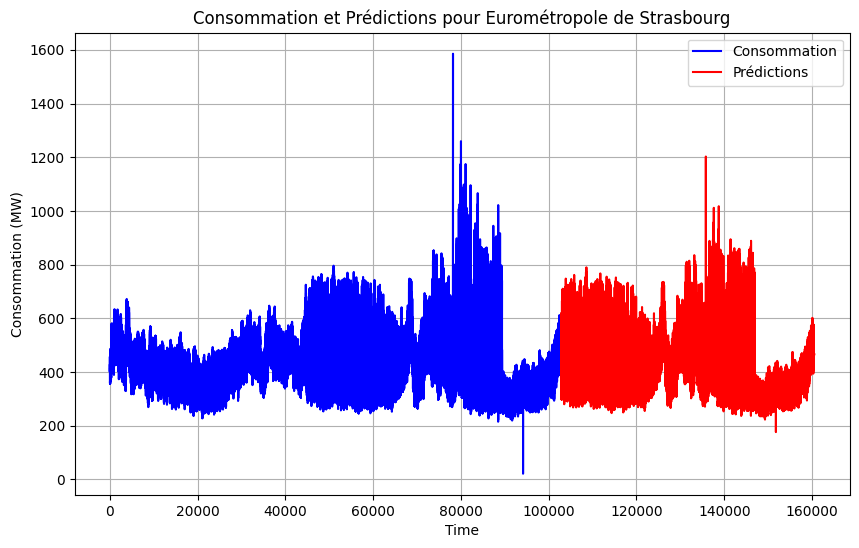

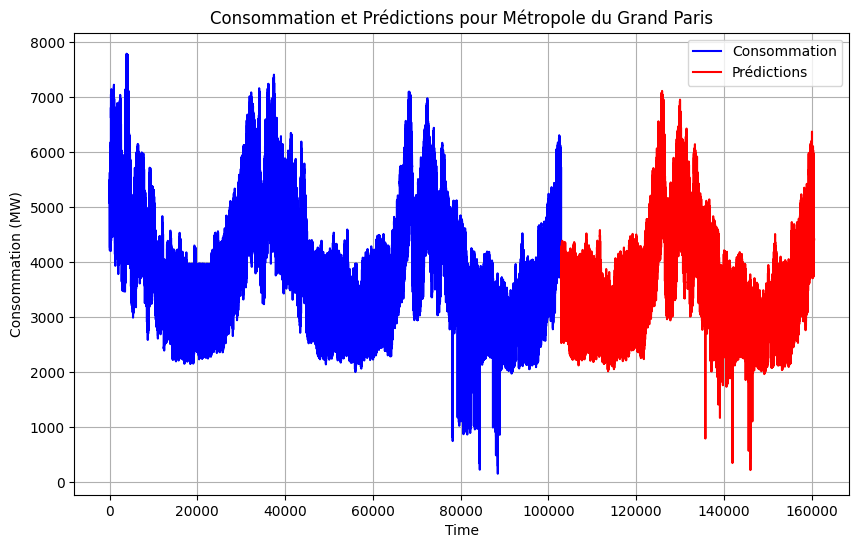

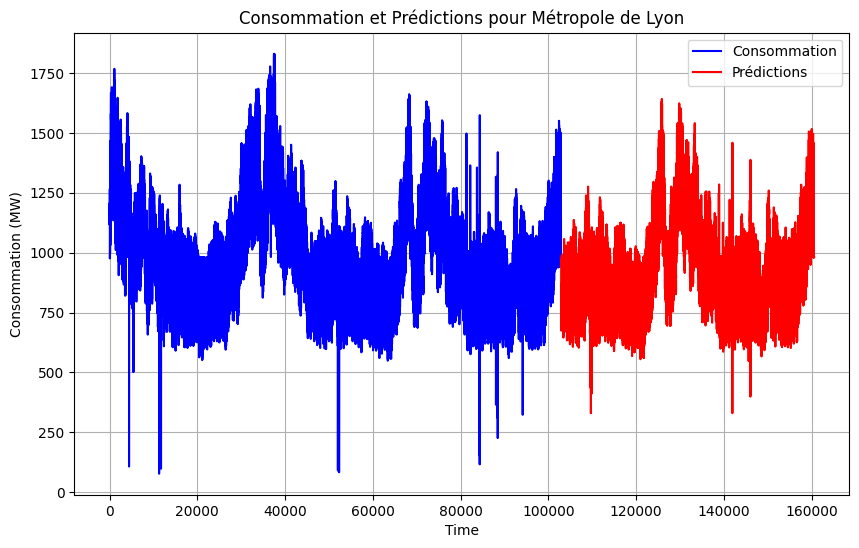

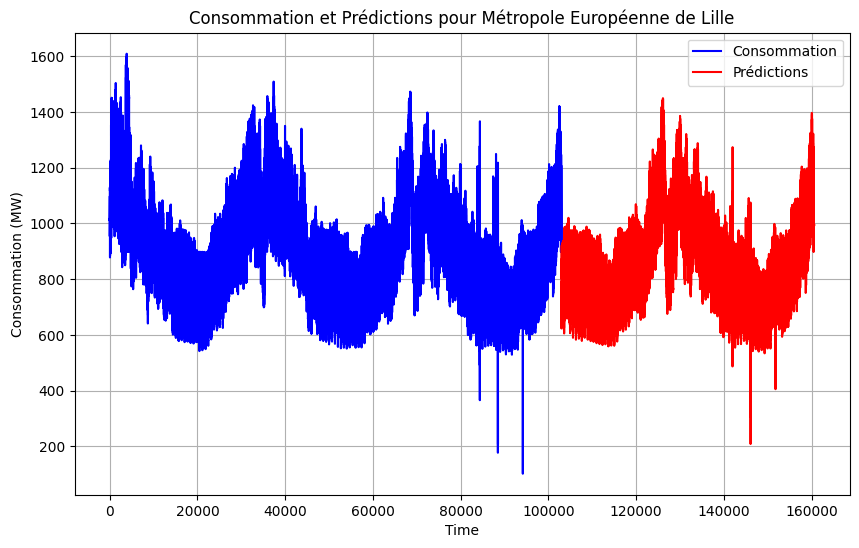

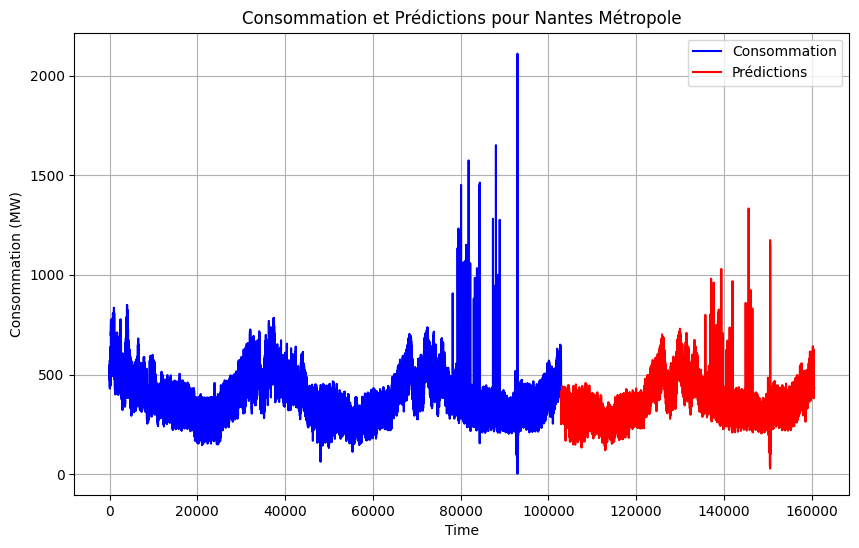

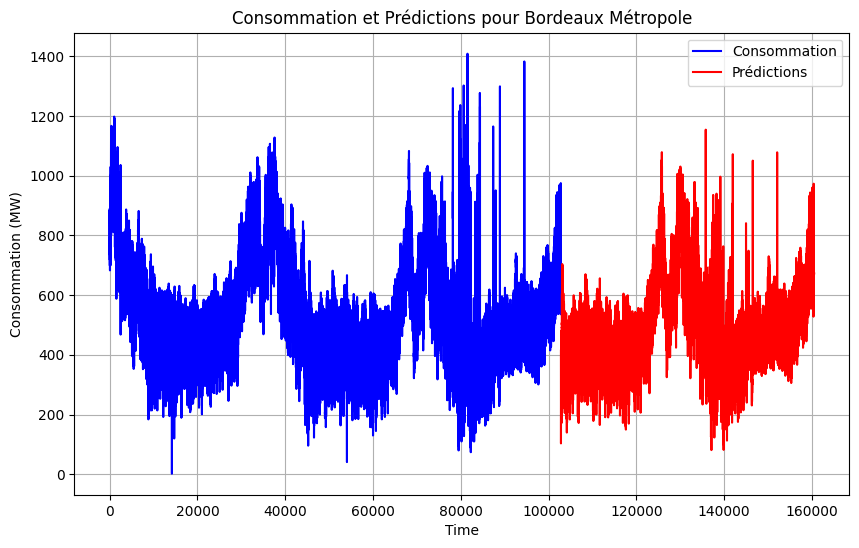

In [103]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Définir l'ordre SARIMA
order = (5, 1, 0)  # Vous pouvez ajuster ces valeurs en fonction de votre analyse




# Boucle sur chaque ville
for ville, consommation in villes_consumption.items():
    # Convertir la série temporelle en tableau numpy
    series = consommation.values

    # Créer un tableau de temps correspondant
    time = np.array(range(len(series)))

    # Créer le modèle SARIMA
    model = SARIMAX(series, order=order)

    seasonality = 24*4  # 24 heures * 4 fois par heure

    
    # Ajuster le modèle aux données avec la seasonality
    model_fit = model.fit(seasonal_order=(1, 0, 1, seasonality))

    # Obtenir les prédictions sur les 20 derniers mois
    predictions = model_fit.predict(start=len(series) - 20*30*24*4, end=len(series) + 24*4)  # 20 mois de prédiction

    # Ajouter les prédictions à cities_predictions
    cities_predictions[ville] = predictions
    
    # Plot de la consommation et des prédictions sur le même graphique
    plt.figure(figsize=(10, 6))
    plt.plot(time, series, label='Consommation', color='blue')
    plt.plot(range(len(series), len(series) + len(predictions)), predictions, label='Prédictions', color='red')
    
    plt.title(f'Consommation et Prédictions pour {ville}')
    plt.xlabel('Time')
    plt.ylabel('Consommation (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()


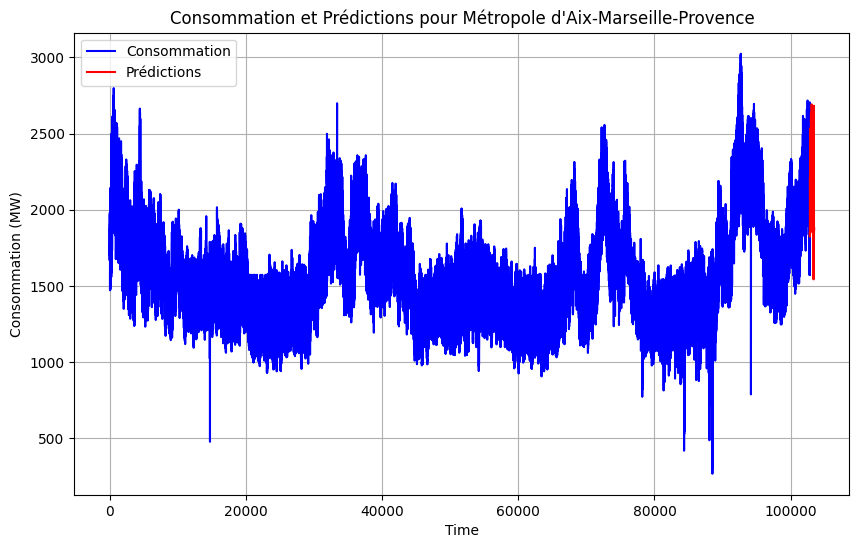

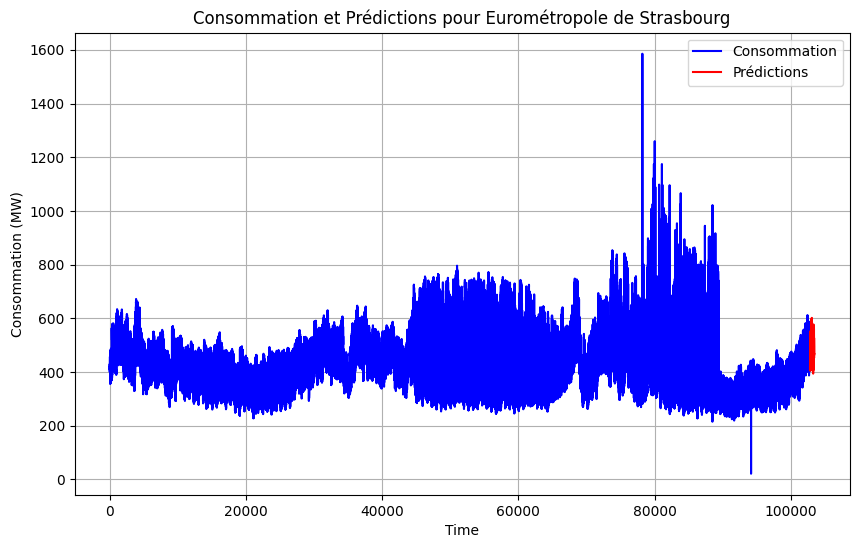

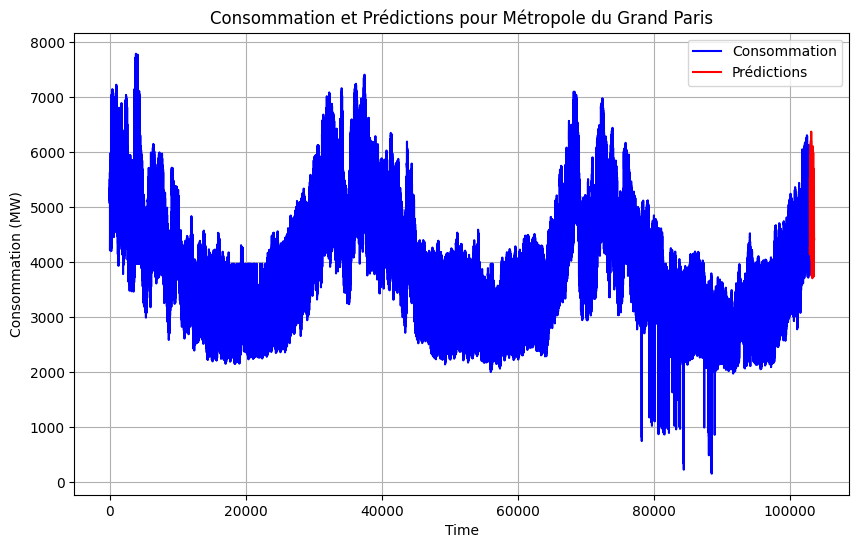

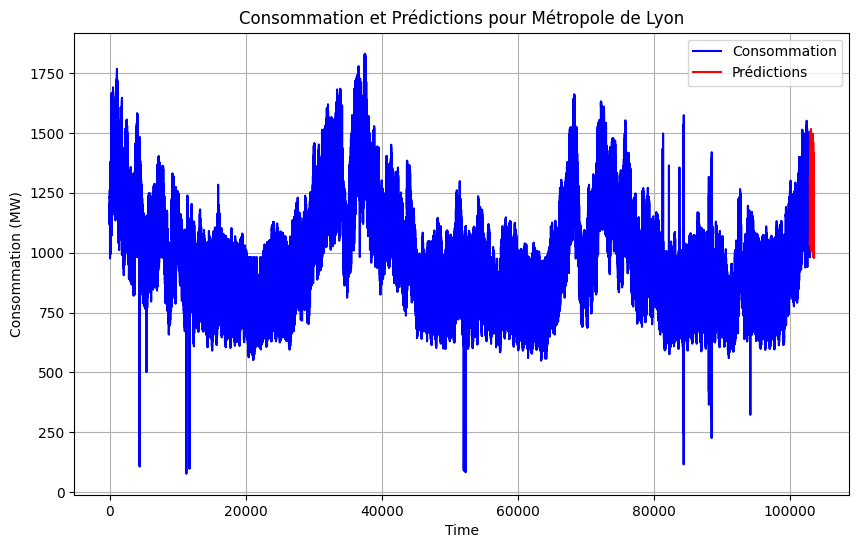

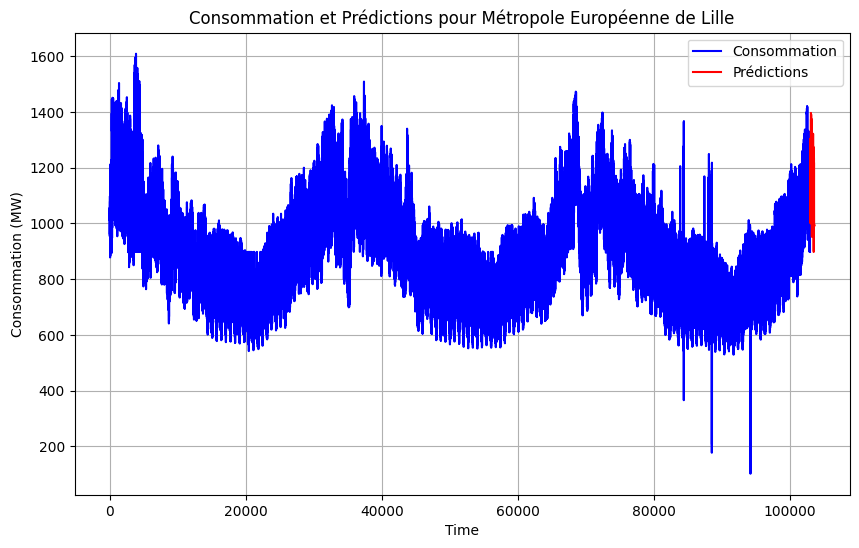

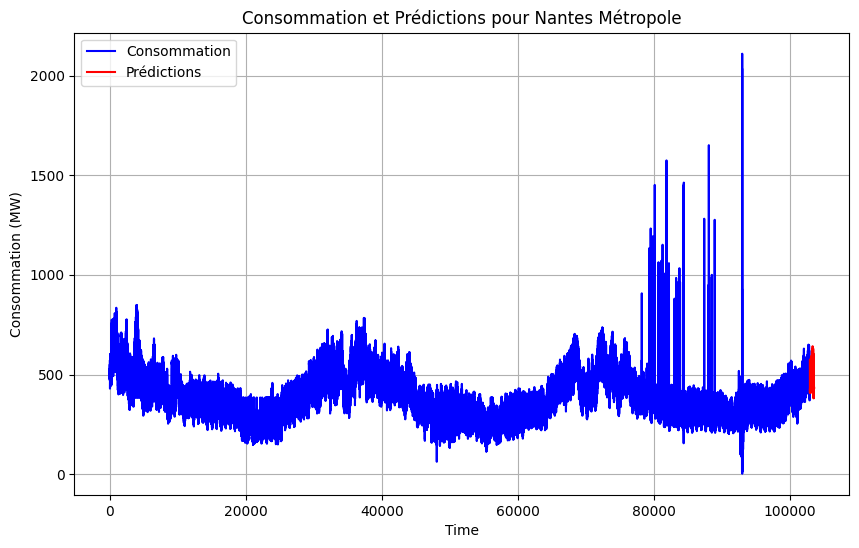

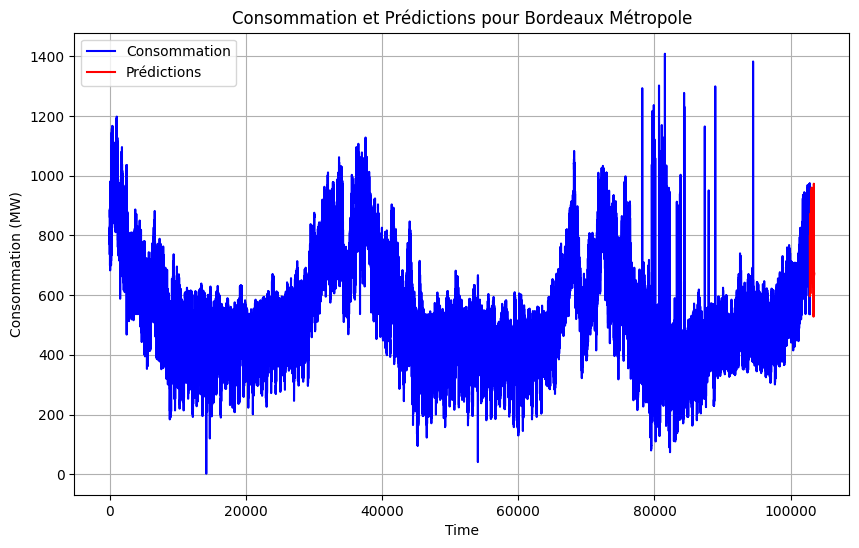

In [104]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Définir l'ordre ARIMA
order = (5, 1, 0)  # Vous pouvez ajuster ces valeurs en fonction de votre analyse

# Boucle sur chaque ville
for ville, consommation in villes_consumption.items():
    # Convertir la série temporelle en tableau numpy
    series = consommation.values

    # Créer un tableau de temps correspondant
    time = np.array(range(len(series)))

    # Créer le modèle ARIMA
    model = ARIMA(series, order=order)
    
    # Ajuster le modèle aux données
    model_fit = model.fit()

    # Obtenir les prédictions sur les 20 derniers mois
    predictions = model_fit.predict(start=len(series) - 20*30, end=len(series) + 30)  # 20 mois de prédiction

    # Plot de la consommation et des prédictions sur le même graphique
    plt.figure(figsize=(10, 6))
    plt.plot(time, series, label='Consommation', color='blue')
    plt.plot(range(len(series), len(series) + len(predictions)), predictions, label='Prédictions', color='red')
    
    plt.title(f'Consommation et Prédictions pour {ville}')
    plt.xlabel('Time')
    plt.ylabel('Consommation (MW)')
    plt.legend()
    plt.grid(True)
    
    # Afficher le graphique interactif pour le zoom
    plt.show()


In [109]:
# save city_predictions dict to csv
import csv

# use this format:
# city1, consumption1, consumption2, consumption3, ...
# city2, consumption1, consumption2, consumption3, ...
# ...
# encode in utf-8 to avoid encoding errors

with open('data/city_predictions.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Métropole', 'Consommation (MW)'])
    for city, predictions in cities_predictions.items():
        writer.writerow([city] + list(predictions))

# with open('data/city_predictions.csv', 'w', encoding='utf-8') as f:
#     w = csv.writer(f)
#     w.writerow(cities_predictions.keys())
#     w.writerows(zip(*cities_predictions.values()))